In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [33]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(17248, 24)
(17248, 4)


In [34]:
min(Y_footsteps_accelerations_absolute[:, 0])

-0.24095147187073118

In [35]:
max(Y_footsteps_accelerations_absolute[:, 0])

0.6532000822579914

# Multivariate Linear Regression (Foot prediction)

In [36]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [37]:
# Entries where FL is swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -2] == 1)[0]
X_footsteps_accelerations_absolute_FL_swinging = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_FL_swinging = Y_footsteps_accelerations_absolute[idxs]

In [38]:
len(idxs)

8638

In [39]:
X_footsteps_accelerations_absolute_FL_swinging[0]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.11232672, -0.02118164, -0.00713002,  0.04701474,
        0.22752666,  0.13133161, -0.3802225 ,  0.2578249 , -0.12791809,
       -0.37706181, -0.24075544,  0.12229743, -0.38356426, -0.26876706,
       -0.12459208, -0.38188431,  1.        ,  0.        ])

In [40]:
Y_footsteps_accelerations_absolute[0]

array([ 0.06153266, -0.00069727,  0.06077899, -0.00427389])

## Predict FL foot -> x

### Linear Regression

In [41]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [52]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FL_swinging[:, 0:1], # actual velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 3:4], # reference velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 10:12], # FL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 13:15], # FR position
               X_footsteps_accelerations_absolute_FL_swinging[:, 16:18], # RL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 19:21])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_relative_support_x = find_best_model(X, Y, runs=5000)

R2:  0.9935474547583647
RMSE:  0.01477132900849018
The lowest error is:  1.6312543739238627e-05
The highest error is:  0.06037373235893967
The avg. error is:  0.010598489669854187


In [55]:
model_fl_relative_support_x.coef_

array([[ 0.17640819,  0.04554312, -1.244799  , -0.37651577, -0.37988994,
         0.48972548,  0.93842165, -0.02524611, -0.89731413, -0.82609749]])

In [56]:
model_fl_relative_support_x.intercept_

array([0.41028988])

In [18]:
inp = np.array([[0.9, 0.661, 0.159, 0.124, 0.331, -0.137, -0.169, 0.119, -0.337, -0.127]])

In [19]:
out = model_fl_relative_support_x.coef_ @ inp.T
out += model_fl_relative_support_x.intercept_
print(out)

[[1.16675601]]


Text(0, 0.5, 'Predictions')

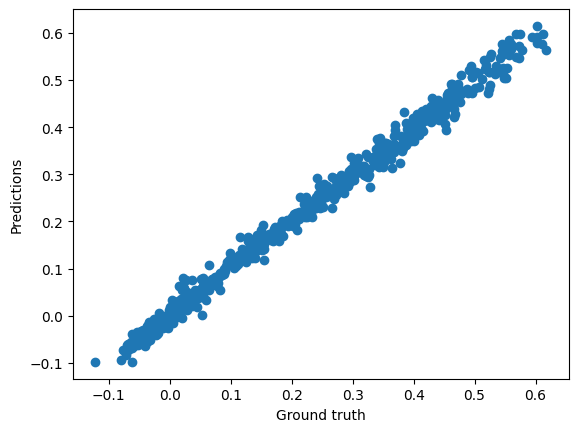

In [57]:
# The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'{X_test[idx, 0]} -> {X_test[idx, 3]}. CoM: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}.')

### Predict FL foot -> y

In [62]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FL_swinging[:, 0:1], # actual velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 3:4], # reference velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 10:12], # FL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 13:15], # FR position
               X_footsteps_accelerations_absolute_FL_swinging[:, 16:18], # RL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 19:21])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_relative_support_y = find_best_model(X, Y, runs=5000)

R2:  0.9352215558594857
RMSE:  0.00744933835760676
The lowest error is:  8.279525506721397e-06
The highest error is:  0.028634801671348825
The avg. error is:  0.005442319966609523


In [63]:
model_fl_relative_support_y.coef_

array([[ 0.01995527, -0.00883563,  0.10590076, -1.76065877,  0.31187311,
         0.54108686, -0.41806758,  0.22429405, -0.30565456, -0.4417862 ]])

In [64]:
model_fl_relative_support_y.intercept_

array([-0.0767492])

Text(0, 0.5, 'Predictions')

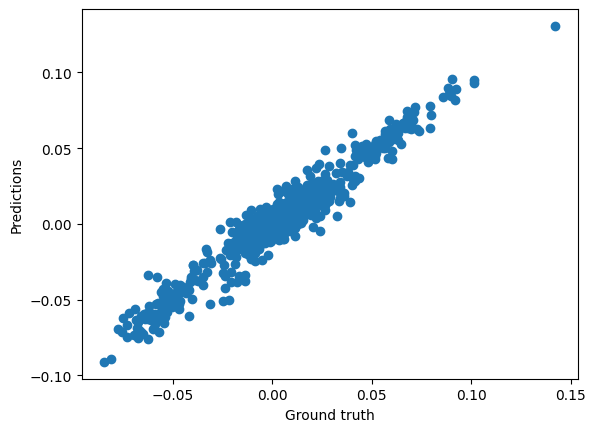

In [65]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [23]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')